In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import ast

In [2]:
# load adjacency matrix
A = np.loadtxt(open("./data/G.csv", "rb"), delimiter=",").astype("float")
G = nx.convert_matrix.from_numpy_array(A)


In [4]:
# compute global properties

print("No. of nodes:", G.number_of_nodes())
print("No. of edges:", G.number_of_edges())
print("Is connected?", nx.is_connected(G))
print("Is directed?", nx.is_directed(G))

###########  network density  ################## 
print("network density:", nx.density(G))

############# avg clustering coefficient  #############
print("Avg clustering coefficient:", np.round(nx.average_clustering(G), 5) )

############### avg shortest path length ################
print("Avg path length:", nx.average_shortest_path_length(G)) 
        
############ diameter   #################
print("diameter: ", nx.diameter(G) )



No. of nodes: 59
No. of edges: 676
Is connected? True
Is directed? False
network density: 0.3950905902980713
Avg clustering coefficient: 0.73285
Avg path length: 1.745178258328463
diameter:  4


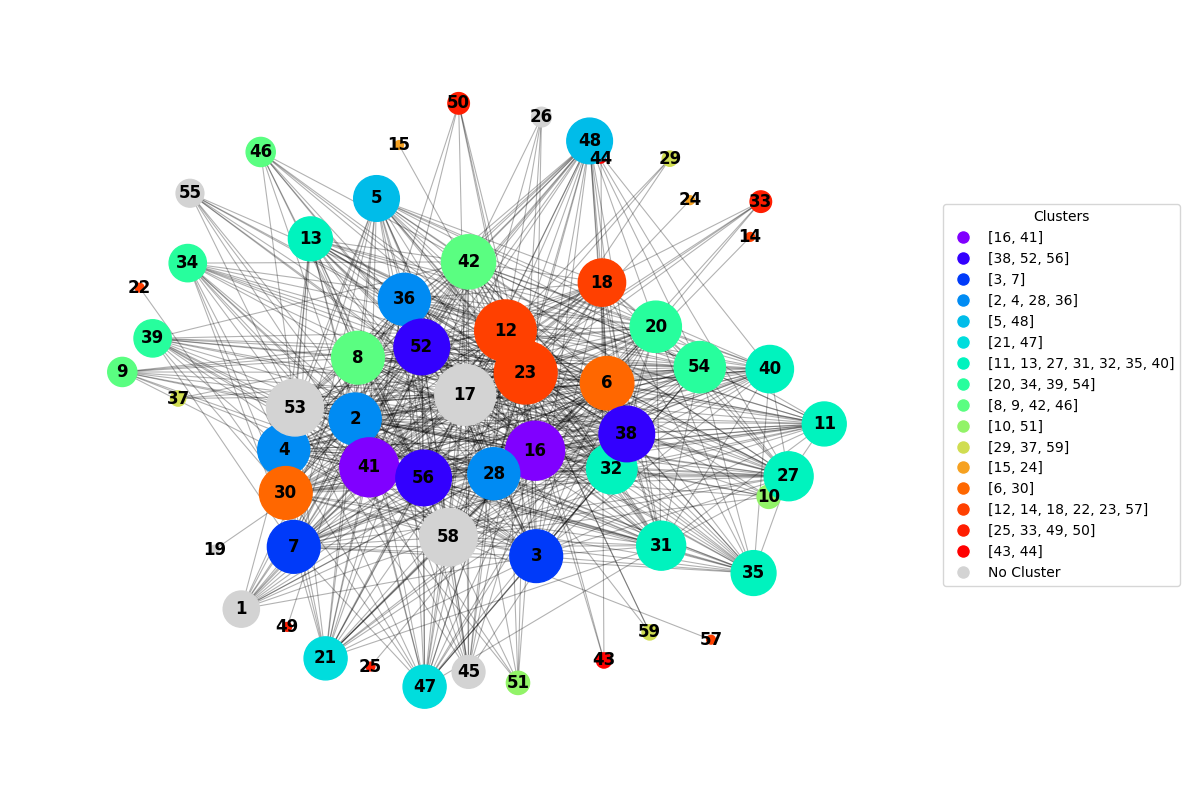

In [43]:
# Load adjacency matrix
A = np.loadtxt(open("./data/G.csv", "rb"), delimiter=",").astype("float")
G = nx.convert_matrix.from_numpy_array(A)
# Relabel nodes to start from 1
G = nx.relabel_nodes(G, {old_label: old_label + 1 for old_label in G.nodes()})


# Load cluster data
cluster_data = pd.read_csv("./data/pred_clusters.csv")
# Load cluster data
#cluster_data = pd.read_csv("./data/pred_clusters.csv", dtype={'lambda_index': int})

# Create a dictionary of clusters
clusters_dict = {}
for _, row in cluster_data.iterrows():
    cluster = eval(row['cluster'])  # Convert string representation of list to actual list
    for node in cluster:
        clusters_dict[node] = row['lambda_index']

# Calculate node degrees
degrees = dict(G.degree())

# Generate colors for clusters
num_clusters = len(cluster_data)
base_colors = cm.rainbow(np.linspace(0, 1, num_clusters))
color = [mcolors.rgb_to_hsv(c[:3]) for c in base_colors]
for c in color:
    c[1] = min(1, c[1] * 1.5)  # Increase saturation by 50%
color = [mcolors.hsv_to_rgb(c) for c in color]

# Create a color map
color_map = {row[1]['lambda_index']: c for row, c in zip(cluster_data.iterrows(), color)}

# Assign colors to nodes
node_colors = []
for node in G.nodes():
    if node in clusters_dict:
        node_colors.append(color_map[clusters_dict[node]])
    else:
        node_colors.append('lightgrey')

# Set up the plot
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2.5, iterations=50)

# Draw the network
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.8)

# Draw nodes
nodes = nx.draw_networkx_nodes(G, pos, 
                               node_size=[v*40 for v in degrees.values()],
                               node_color=node_colors)

# Add labels to nodes
labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight='bold')

# Customize the plot
#plt.title("Network Visualization with Nodes Colored by Clusters", fontsize=18)
plt.axis('off')
# Add a legend with cluster lists
legend_elements = []
for _, row in cluster_data.iterrows():
    cluster_list = ast.literal_eval(row['cluster'])
    legend_label = f"{cluster_list}"
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=legend_label,
                                      markerfacecolor=color_map[row['lambda_index']], markersize=10))

legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='No Cluster',
                                  markerfacecolor='lightgrey', markersize=10))

# Add the legend
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Clusters")

# Adjust the plot to ensure all elements are visible
plt.tight_layout()
plt.margins(0.1)
plt.savefig("./images/ncm_network_vis.pdf", 
                facecolor="white", bbox_inches="tight", dpi=600)
# Show the plot
plt.show()

# Network overlayed on circuit board

In [2]:
node_df = pd.read_csv("./data/nodelist.csv")
node_dict =  dict(list(zip(node_df['id'], node_df['node'])))

edge_df = pd.read_csv("./data/edgelist.csv")

nodes = list(node_dict.values())
edges = list(zip(edge_df['source'], edge_df['target']))


In [3]:
# Load cluster data
cluster_data = pd.read_csv("./data/pred_clusters.csv")
# Load cluster data
#cluster_data = pd.read_csv("./data/pred_clusters.csv", dtype={'lambda_index': int})

# Create a dictionary of clusters
clusters_dict = {}
for _, row in cluster_data.iterrows():
    cluster = eval(row['cluster'])  # Convert string representation of list to actual list
    for node in cluster:
        clusters_dict[node] = row['lambda_index']

In [4]:
node_cluster_map = {}
for node_num, cluster in clusters_dict.items():
    node_cluster_map[node_dict[node_num]] = cluster

In [5]:
# Generate colors for clusters

num_clusters = len(cluster_data)
base_colors = cm.rainbow(np.linspace(0, 1, num_clusters))
color = [mcolors.rgb_to_hsv(c[:3]) for c in base_colors]
for c in color:
    c[1] = min(1, c[1] * 1.5)  # Increase saturation by 50%
color = [mcolors.hsv_to_rgb(c) for c in color]

# Create a color map
color_map = {row[1]['lambda_index']: c for row, c in zip(cluster_data.iterrows(), color)}

# Assign colors to nodes
nodenum_colors = {}
for node in list(node_dict.keys()):
    if node in list(clusters_dict.keys()):
        nodenum_colors[node] = color_map[clusters_dict[node]]
    else:
        nodenum_colors[node]='lightgrey'


In [8]:
node_color_map = {}
for nodenum, color in nodenum_colors.items():
    node_color_map[node_dict[nodenum]] = color

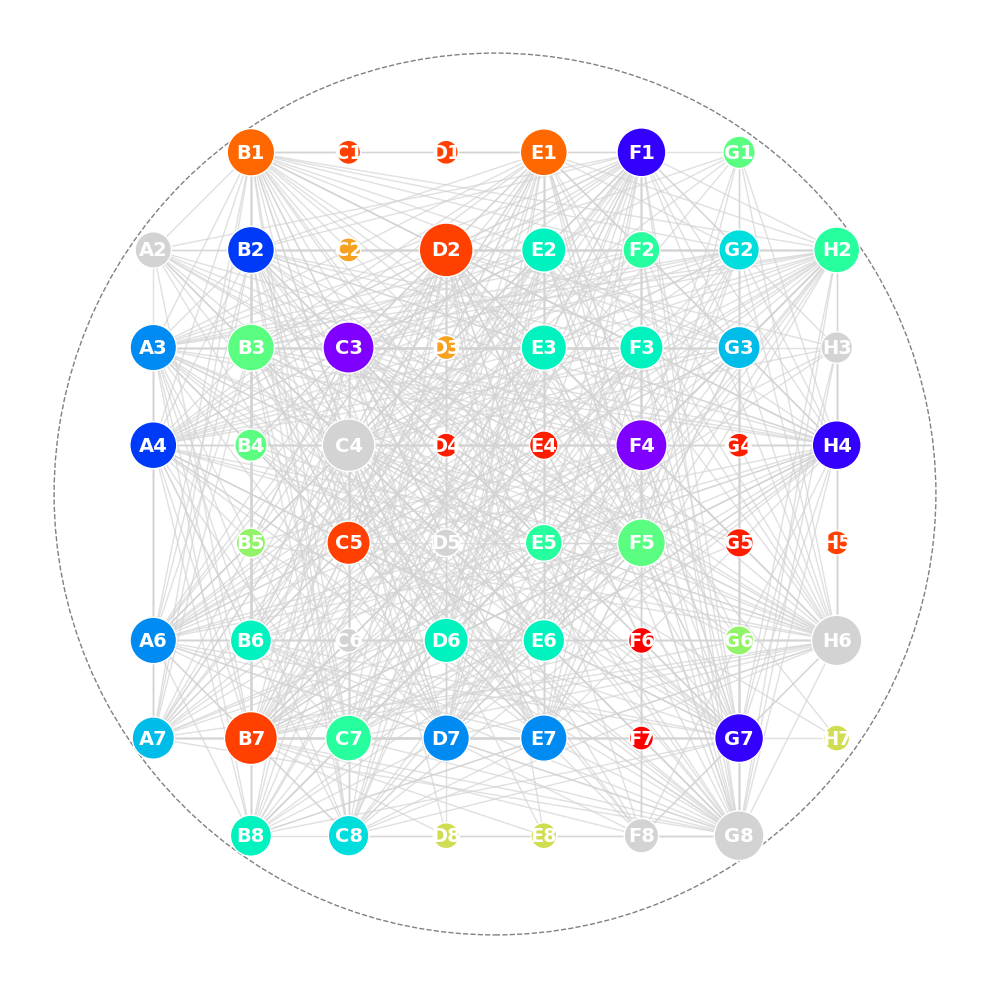

In [23]:
# First calculate degrees for each node
degrees = {}
for node in nodes:
    degrees[node] = 0

for edge in edges:
    degrees[edge[0]] += 1
    degrees[edge[1]] += 1

# Convert degrees to array in the same order as nodes
node_degrees = np.array([degrees[node] for node in nodes])

# Scale degrees to reasonable node sizes (adjust min/max size as needed)
min_size = 300  # Minimum node size
max_size = 1500  # Maximum node size
scaled_sizes = min_size + (max_size - min_size) * (node_degrees - np.min(node_degrees)) / (np.max(node_degrees) - np.min(node_degrees))


# Convert to polar coordinates
x = np.array([ord(node[0]) - ord('A') for node in nodes])  # A=0, B=1, ..., H=7
y = np.array([8 - int(node[1:]) for node in nodes])  # Inverted y-axis (row 1 at top)

center_x, center_y = 3.5, 3.5  # Center of original grid
theta = np.arctan2(y - center_y, x - center_x)
radius = np.sqrt((x - center_x)**2 + (y - center_y)**2)
max_radius = np.max(radius)

# Normalize and scale for circular arrangement
scale_factor = 1.2  # Adjust to control how tight the circle is
circle_radius = 15
scaled_radius = radius / max_radius * scale_factor * circle_radius

# Convert back to Cartesian coordinates
circle_x = scaled_radius * np.cos(theta) + circle_radius
circle_y = scaled_radius * np.sin(theta) + circle_radius

# Create plot
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Draw edges first (so they appear behind nodes)
for edge in edges:
    # Get indices of source and target nodes
    src_idx = nodes.index(edge[0])
    tgt_idx = nodes.index(edge[1])
    
    # Draw line between connected nodes
    ax.plot([circle_x[src_idx], circle_x[tgt_idx]],
            [circle_y[src_idx], circle_y[tgt_idx]],
            color='lightgray', linewidth=1, alpha=0.7, zorder=1)

# Draw nodes on top of edges with size proportional to degree
ax.scatter(circle_x, circle_y, color=list(node_color_map.values()), s=scaled_sizes, 
           edgecolor='white', linewidth=1, zorder=2)

# Label nodes (unchanged)
for i, node in enumerate(nodes):
    ax.text(circle_x[i], circle_y[i], node, 
            ha='center', va='center', 
            color='white', fontsize=14, fontweight='bold', zorder=3)

# Rest of the code remains unchanged
border_circle = plt.Circle((circle_radius, circle_radius), 
                         circle_radius * scale_factor * 1.05,
                         fill=False, 
                         color='gray', 
                         linestyle='--', 
                         linewidth=1)
ax.add_patch(border_circle)
# Set equal aspect and remove axes
ax.set_aspect('equal')
ax.axis('off')
#plt.title('Network overlayed on the circuit', pad=20, fontsize=14)
plt.tight_layout()
plt.savefig("./images/ncm_net_clusterSync.pdf", 
           facecolor="white", bbox_inches="tight", dpi=600)
plt.show()



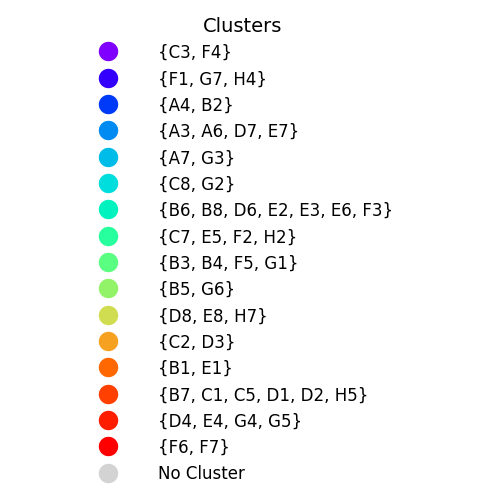

In [28]:
# --- Legend Plot (Right Plot) ---
# Create legend elements
# Create plot
plt.figure(figsize=(6, 6))
legend_elements = []
for _, row in cluster_data.iterrows():
    cluster_list = ast.literal_eval(row['cluster'])
    cluster_list = [node_dict[num] for num in cluster_list]
    legend_label = "{" + ", ".join(cluster_list) + "}"
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=legend_label,
                                    markerfacecolor=color_map[row['lambda_index']], markersize=15))

legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='No Cluster',
                                markerfacecolor='lightgrey', markersize=15))

# Create legend in the right subplot
plt.axis('off')  # Turn off axes for legend plot
legend = plt.legend(handles=legend_elements, loc='center', 
                   title="Clusters", frameon=False,
                   handletextpad=2, fontsize=12)
legend.get_title().set_fontsize(14)  # Larger title font

# Adjust layout and save
#plt.tight_layout()
plt.savefig("./images/clustersColor_legend.pdf", 
           facecolor="white", bbox_inches="tight", dpi=600)
plt.show()

# EXTRA

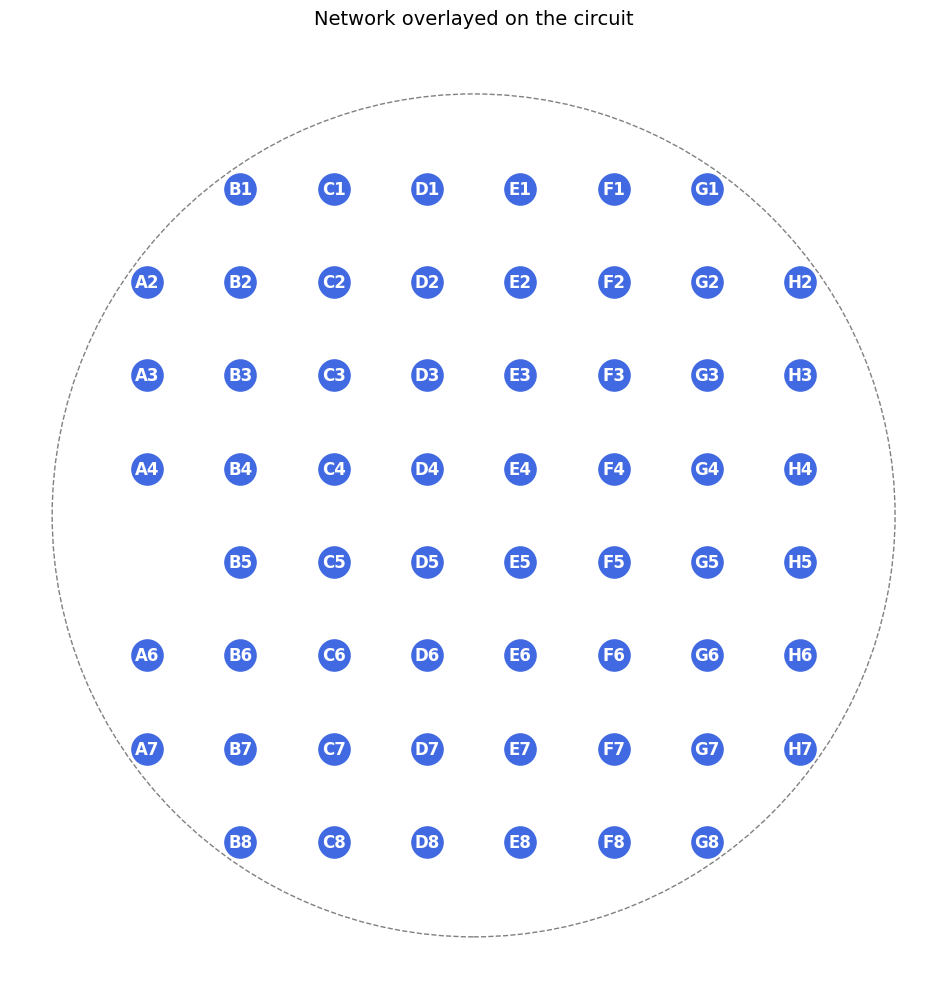

In [58]:

# Convert to polar coordinates
x = np.array([ord(node[0]) - ord('A') for node in nodes])  # A=0, B=1, ..., H=7
y = np.array([8 - int(node[1:]) for node in nodes])  # Inverted y-axis (row 1 at top)

center_x, center_y = 3.5, 3.5  # Center of original grid
theta = np.arctan2(y - center_y, x - center_x)
radius = np.sqrt((x - center_x)**2 + (y - center_y)**2)
max_radius = np.max(radius)

# Normalize and scale for circular arrangement
scale_factor = 0.9  # Adjust to control how tight the circle is
circle_radius = 12
scaled_radius = radius / max_radius * scale_factor * circle_radius

# Convert back to Cartesian coordinates
circle_x = scaled_radius * np.cos(theta) + circle_radius
circle_y = scaled_radius * np.sin(theta) + circle_radius

# Create plot
plt.figure(figsize=(10, 10))
ax = plt.gca()

# Draw nodes
ax.scatter(circle_x, circle_y, color='royalblue', s=600, edgecolor='white', linewidth=1)

# Label nodes
for i, node in enumerate(nodes):
    ax.text(circle_x[i], circle_y[i], node, 
            ha='center', va='center', 
            color='white', fontsize=12, fontweight='bold')

# Draw circular border
border_circle = plt.Circle((circle_radius, circle_radius), 
                          circle_radius * scale_factor * 1.05,  # Slightly larger than nodes
                          fill=False, 
                          color='gray', 
                          linestyle='--', 
                          linewidth=1)
ax.add_patch(border_circle)

# Set equal aspect and remove axes
ax.set_aspect('equal')
ax.axis('off')
plt.title('Network overlayed on the circuit', pad=20, fontsize=14)
plt.tight_layout()
#plt.savefig("./images/ncm_net_clusterSync.pdf", 
#                facecolor="white", bbox_inches="tight", dpi=600)
plt.show()